# How Much Is Delay Costing You? A City-Level View of Courier Inefficiency

## 🎯 Objective
This project analyzes courier pickup responsiveness using real-world task data from five Chinese cities.  
We focus on measuring the **time gap between when a courier accepts a task and when they pick it up**, which we define as **pickup delay**.

Our goal is to:
- Detect where pickup delay consistently exceeds expectations
- Understand which cities or times of day experience hidden time losses
- Recommend smarter benchmarks and interventions based on city workload

We exclude scheduled or delivery-related delays and only focus on **real-time tasks** (≤ 60 minutes delay).

---

## 📂 Dataset Overview
- Source: [LaDe dataset](https://huggingface.co/datasets/Cainiao-AI/LaDe) from Alibaba Cainiao (5 Chinese cities)
- Focus: Pickup-related timestamps (accept, pickup), courier ID, city, and date
- Total Real-Time Tasks: **115,130**
- Cities: **Shanghai, Hangzhou, Chongqing, Yantai, Jilin**

---

## ❓ Business Questions Addressed
1. *How long do couriers wait between accepting and picking up tasks?*
2. *At what point does pickup delay become a problem?*
3. *How many tasks exceed city thresholds?*
4. *How does pickup performance vary by time?*
5. *How much avoidable time is being lost every day?*
6. *Can we forecast future responsiveness trends — or at least monitor them for early warning signals?*


---

## 🔍 Key Insights

- When converted to operational cost, excess pickup delays result in **thousands of RMB lost daily**.
  Using a conservative 0.1 RMB/min estimate, peak delay days cost **over 8,000 RMB**, with Shanghai,    Jilin, and Yantai leading in total loss.

  This reframes delay not just as inefficiency — but as measurable waste.

- **Average pickup delay** across all tasks: **~30.96 minutes**

- **Highest excess delay rate**:
  
   - **Jilin** → ~73% of tasks exceeded city threshold  
   - **Yantai** → ~66%


- **Thresholds were not fixed**, *which define what is considered excess and what is reasonable delay* — they were customized per city using a **tasks-per-courier ratio**.  
   - Cities with more courier workload were given higher delay tolerance.  
   - Example: Shanghai & Hangzhou → threshold = 30 mins; Jilin → threshold = 15 mins

- **Delays are time-sensitive**:  
   - Delay is **worst in early morning hours** (4–6 AM), peaking above **42 minutes**  
   - Delay drops significantly during mid-day hours

- **Delay is high every day**:  
   - 50–55% of tasks exceed their city-specific threshold **on every single weekday**

- **Lost time adds up fast**:  
   - On peak days, excess delay reaches **over 80,000 minutes lost in a single day**


- The 7-day rolling average of pickup delay shows a **slow upward trend** — While this isn't a forecast, it suggests a potential deterioration in responsiveness — although more data is needed to confirm whether this is part of a longer-term cycle or a short-term anomaly.
  
---

## ✅ Recommendations

- **Use city-specific pickup delay benchmarks instead of one-size-fits-all thresholds**

In most operations, performance is judged using blanket SLAs (e.g., “pickup must happen within 15 minutes”). But this approach ignores the structural differences across cities.

In this project, I designed **custom thresholds** based on the actual task-per-courier load in each city. For example:

- Cities with fewer couriers but higher workload (e.g., Shanghai) naturally experience longer pickup delays — not because of inefficiency, but because couriers have more to do.
- Judging such cities against a flat 15-minute benchmark would unfairly penalize them.

By assigning higher thresholds to high-load cities, and stricter ones to low-load cities, we get a fairer and more realistic measure of performance. This makes the analysis more tailored, and the insights more trustworthy for decision-making.

- **Address early-morning pickup delays more strategically**

The biggest pickup delays occur between 4:00–6:00 AM, with average delays exceeding 40+ minutes.
These early hours likely represent urgent or time-sensitive requests — people don't schedule pickups at 4 AM unless it matters. However, courier availability appears limited at that time.
This can be improved by:
1. Offering incentives or surge pay to couriers during off-hours
2. Testing higher delivery pricing tiers to offset cost of faster night delivery
3. Implementing a "priority mode" for critical pickups, where users can optionally pay more for faster dispatch from farther couriers.

Solving early-morning lag isn't just about speed — it improves trust in critical moments.

- **Create dynamic alert thresholds for daily monitoring**

Excess delay is a signal.
When over 50% of tasks exceed thresholds on any given day, that day should be flagged as an operational risk.
A dynamic alerting system that triggers when excess delay exceeds a moving baseline (e.g., 50% of tasks) can help ops teams preemptively adjust staffing or incentives.
This is especially useful for sudden demand surges (weekends, weather spikes) where manual oversight may lag.

- **Monitor delay trends using rolling averages — even without forecasting**

Our dataset is too short for reliable ARIMA/Holt-Winters forecasting.
But monitoring the 7-day rolling average of pickup delays still offers huge value.
For instance, the rolling average shows a rising trend in delays — this should be a warning flag.
With this rolling view, companies can:
1. Adding staff during pressure periods
2. Temporarily adjusting SLAs
3. Offering incentives or discounts to shift demand
4. 
If the trend levels off or reverses, it also helps evaluate the impact of interventions.

- **Investigate why Jilin and Yantai underperform despite low workloads**
  
Jilin and Yantai have the lowest task-per-courier ratios — 5.0 and 13.0 respectively — but also the highest rates of delay (Jilin: 73% over threshold).
That’s counterintuitive. In high-load cities like Shanghai (19 tasks/courier), delays are lower.
This anomaly suggests that the problem in Jilin and Yantai is not volume, but potentially courier inefficiency, routing issues, uneven courier distribution (i.e., supply exists, but not where demand is)
These cities need targeted diagnostics, not just more couriers. They’re outliers — and that’s a clue worth exploring.

---

*This project combines data cleaning, timestamp parsing, business metric engineering, and time-based performance analysis using Python, pandas, seaborn and statsmodels.*


In [1]:
#Loading pickup dataset and preview 
import pandas as pd

pickup = pd.read_csv(r"C:\Users\shamb\Desktop\LaDe Analysis project\pickup_five_cities.csv", low_memory = False)
pickup.sample(2)

,order_id,from_dipan_id,from_city_name,delivery_user_id,accept_time,book_start_time,expect_got_time,poi_lng,poi_lat,aoi_id,typecode,got_time,got_gps_time,got_gps_lng,got_gps_lat,accept_gps_time,accept_gps_lng,accept_gps_lat,ds
89107,a3750d13dc16cc68dc997b46148c6507,1bba903f57c9898f42e79f93c973f19e,杭州市,4c5aa39ba3949c19fb2035d751bcb6f1,03-25 07:25:00,03-25 09:00:00,03-25 11:00:00,1.041583e+07,-7.589947e+06,8f9863cf74100f4ad2a6e3c3ec1af2a5,203ac3454d75e02ebb0a3c6f51d735e4,03-25 10:24:00,NaN,NaN,NaN,NaN,NaN,NaN,325
181646,172fa1d4cf9fcf495ffe51b5751b7960,15b6b2ddb15988c5626c2d451fbecd36,上海市,0e9575d1bd8500f68599f1d08b1e1c02,03-20 13:03:00,03-20 15:00:00,03-20 17:00:00,1.057286e+07,-7.464493e+06,58efe5062698511e2fcfcf45eea4df9c,203ac3454d75e02ebb0a3c6f51d735e4,03-20 15:06:00,NaN,NaN,NaN,NaN,NaN,NaN,320


In [2]:
pickup.shape

(531115, 19)

In [3]:
#Renaming raw column names to match LaDe documentation
pickup.rename(columns={
    "order_id": "package_id",
    "delivery_user_id": "courier_id",
    "from_city_name": "city",
    "got_time": "pickup_time"
}, inplace=True)

In [4]:
pickup["city"].unique()

array(['杭州市', '烟台市', '上海市', '重庆市', '吉林市'], dtype=object)

In [5]:
#Translating city names from Mandarin to english
city_translation = {
     "杭州市": "hangzhou",
    "烟台市": "yantai",
    "上海市": "shanghai",
    "重庆市": "chongqing",
    "吉林市": "jilin"
}
pickup["city"] = pickup["city"].replace(city_translation)
pickup["city"].unique()

array(['hangzhou', 'yantai', 'shanghai', 'chongqing', 'jilin'],
      dtype=object)

In [6]:
pickup.dtypes

package_id          object
from_dipan_id       object
city                object
courier_id          object
accept_time         object
book_start_time     object
expect_got_time     object
poi_lng            float64
poi_lat            float64
aoi_id              object
typecode            object
pickup_time         object
got_gps_time        object
got_gps_lng        float64
got_gps_lat        float64
accept_gps_time     object
accept_gps_lng     float64
accept_gps_lat     float64
ds                   int64
dtype: object

Over 87% of GPS-related fields are missing, with some at 100%. Since our analysis focuses on pickup timing (not geolocation tracking), we are removing these and other unnecessary columns from the dataset.

In [7]:
#Keep original full dataset
pickup_raw = pickup.copy()
#Droping columns not needed from the working version
columns_to_drop = [
"from_dipan_id", "book_start_time", "expect_got_time", "poi_lng", "poi_lat", "aoi_id", "typecode",
    "got_gps_time", "got_gps_lng", "got_gps_lat","accept_gps_time", "accept_gps_lng", "accept_gps_lat"
]

pickup.drop(columns=columns_to_drop, inplace=True)
pickup.sample(2)

,package_id,city,courier_id,accept_time,pickup_time,ds
369585,25f7b02a74f5de9879513bc978557bdb,hangzhou,300b50daffdcac21a84e6b62ab9c42e4,03-18 16:12:00,03-18 17:48:00,318
145812,f433ce4f776af4a2c82d680728902a62,hangzhou,97987393736c30bed72eb1828997f2c0,03-23 08:05:00,03-23 11:00:00,323


#### Converting Time Columns & Creating Delay

We now convert the key time columns to datetime format so we can calculate delays.

The original dataset includes time information in the format "MM-DD HH:MM:SS" but does not include the year. To enable time-based calculations like delay durations and hourly trends, we assign a placeholder year 2024 during parsing.

This does not affect the interpretation of the results, as we are not analyzing calendar-based trends — only intra-day and intra-week patterns.

We'll create a new column called `pickup_delay_minutes` by taking the difference between `pickup_time` and `accept_time` (in minutes).

Finally, we filter the data to keep only **real-time tasks**, which we define as those with a delay of **60 minutes or less**.

In [8]:
# Assigning dummy year and converting time strings to datetime objects
pickup["accept_time"] = pickup["accept_time"].str.strip()
pickup["pickup_time"] = pickup["pickup_time"].str.strip()

from datetime import datetime

pickup["accept_time"] = pickup["accept_time"].astype(str).apply(
    lambda x: datetime.strptime("2024-" + x, "%Y-%m-%d %H:%M:%S"))

pickup["pickup_time"] = pickup["pickup_time"].astype(str).apply(
    lambda x: datetime.strptime("2024-" + x, "%Y-%m-%d %H:%M:%S"))

# Converting ds from day-of-year to full date in 2024
pickup["ds"] = pd.to_datetime(pickup["ds"], format="%j", errors="coerce")
pickup["ds"] = pickup["ds"].apply(lambda x: x.replace(year=2024))
pickup.sample(2)

,package_id,city,courier_id,accept_time,pickup_time,ds
248352,ab718b724060687a08bd8cea3bbac04d,hangzhou,657b73f53deeb803b104cab504e6cc23,2024-03-31 08:07:00,2024-03-31 09:17:00,2024-11-27
253135,a7f3d4b91668aae979470a0807e73b03,hangzhou,4bf857b01ebf3be1fdb36292f2ba1e1e,2024-03-31 12:11:00,2024-03-31 13:02:00,2024-11-27


In [9]:
pickup.dtypes

package_id             object
city                   object
courier_id             object
accept_time    datetime64[ns]
pickup_time    datetime64[ns]
ds             datetime64[ns]
dtype: object

In [10]:
#Calculating pickup delay in minutes 
pickup["pickup_delay_minutes"] = (pickup["pickup_time"] - pickup["accept_time"]).dt.total_seconds()/60
pickup[["pickup_delay_minutes"]].sample(2)

,pickup_delay_minutes
472924,150.0
496832,14.0


In [11]:
# Filter: only real-time tasks (<= 60 min delay)
pickup = pickup[pickup["pickup_delay_minutes"] <= 60].copy()

print("Remaining real-time tasks:", pickup.shape[0])
pickup[["accept_time", "pickup_time", "pickup_delay_minutes"]].sample(5)

Remaining real-time tasks: 115310


,accept_time,pickup_time,pickup_delay_minutes
71947,2024-03-25 10:01:00,2024-03-25 10:04:00,3.0
226466,2024-04-01 07:12:00,2024-04-01 08:01:00,49.0
407585,2024-03-22 09:00:00,2024-03-22 09:33:00,33.0
84133,2024-03-25 17:04:00,2024-03-25 17:58:00,54.0
244273,2024-03-31 16:00:00,2024-03-31 16:47:00,47.0


#### Exploratory Delay Analysis

Before applying any thresholds, it's important to understand the overall distribution and behavior of pickup delays.

We'll start by computing summary statistics such as average, median, and standard deviation of `pickup_delay_minutes`.

Next, we'll visualize the distribution of delays across all cities to get a sense of variation and typical wait times. We'll also break down the average pickup delay per city to spot early differences.

Pickup delay summary (in minutes):
       pickup_delay_minutes
count         115310.000000
mean              30.963091
std               17.331561
min                0.000000
25%               16.000000
50%               31.000000
75%               46.000000
max               60.000000


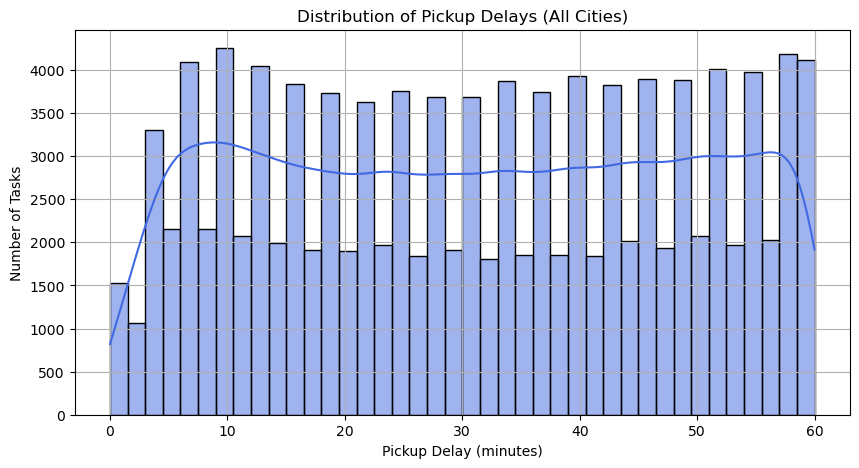

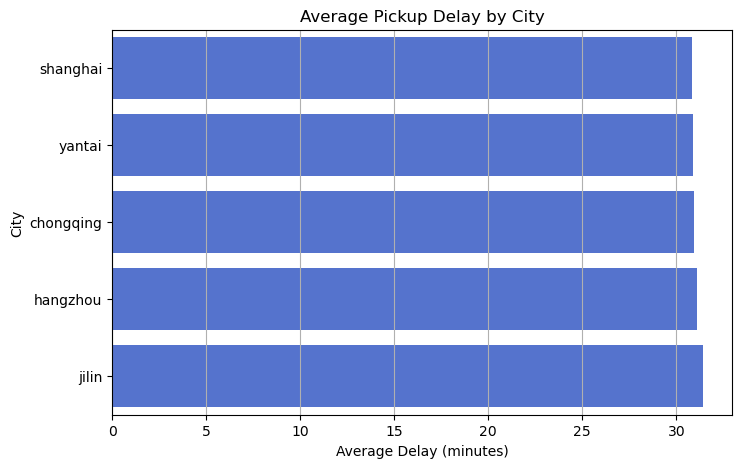

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary statistics
print("Pickup delay summary (in minutes):")
print(pickup[["pickup_delay_minutes"]].describe())

# Histogram of all pickup delays
plt.figure(figsize=(10, 5))
sns.histplot(pickup["pickup_delay_minutes"], bins=40, kde=True, color="royalblue")
plt.title("Distribution of Pickup Delays (All Cities)")
plt.xlabel("Pickup Delay (minutes)")
plt.ylabel("Number of Tasks")
plt.grid(True)
plt.show()

# Bar chart: average pickup delay per city
plt.figure(figsize=(8, 5))
city_avg = pickup.groupby("city")["pickup_delay_minutes"].mean().sort_values().reset_index()

sns.barplot(
    data=city_avg,
    x="pickup_delay_minutes",
    y="city",
    color="royalblue",
    legend=False
)

plt.title("Average Pickup Delay by City")
plt.xlabel("Average Delay (minutes)")
plt.ylabel("City")
plt.grid(axis="x")
plt.show()

#### City-Specific Thresholds

At first glance, one might be tempted to assess pickup responsiveness using a **fixed time threshold** (for example, 15 minutes). While this can offer a quick benchmark, it assumes that all cities operate under similar conditions — which is rarely true.

This approach ignores important operational differences such as:
- Number of available couriers
- Volume of tasks in a city
- Urban density and traffic conditions

Instead of applying a single fixed number, we define **custom thresholds per city** based on actual data — specifically, the **tasks-per-courier ratio**. Cities with a higher ratio likely face more courier workload and may require a more flexible benchmark.

The logic is:
- Higher tasks-per-courier → Couriers are more stretched → More delay is acceptable
- Lower tasks-per-courier → Couriers are less loaded → Delays should be shorter

This gives us a more fair and realistic way to judge performance across different operational contexts.

In [13]:
# Calculating total tasks and number of couriers per city
city_task_stats = pickup.groupby("city").agg(
    total_tasks=("courier_id", "size"), #each row = one task
    num_couriers=("courier_id", "nunique")
)
city_task_stats

,total_tasks,num_couriers
city,,
chongqing,23848,1493
hangzhou,38038,2070
jilin,1666,305
shanghai,35540,1835
yantai,16218,1301


In [14]:
# Computing tasks-per-courier
city_task_stats["tasks_per_courier"] = round(city_task_stats["total_tasks"] / city_task_stats["num_couriers"])
city_task_stats = city_task_stats.sort_values("tasks_per_courier", ascending=False)
city_task_stats

,total_tasks,num_couriers,tasks_per_courier
city,,,
shanghai,35540,1835,19.0
hangzhou,38038,2070,18.0
chongqing,23848,1493,16.0
yantai,16218,1301,12.0
jilin,1666,305,5.0


In [15]:
# Defining thresholds based on workload logic
thresholds = {}
for city, row in city_task_stats.iterrows():
    ratio = row["tasks_per_courier"]
    if ratio > 15:
        thresholds[city] = 30  # high workload → relaxed threshold
    elif ratio > 10:
        thresholds[city] = 20  # medium workload
    else:
        thresholds[city] = 15  # low workload → strict threshold
print("City-Specific Thresholds (in minutes):")
for city, th in thresholds.items():
    print(f"{city}: {th}")

City-Specific Thresholds (in minutes):
shanghai: 30
hangzhou: 30
chongqing: 30
yantai: 20
jilin: 15


#### Flagging Excess Delays

Now that we’ve established city-specific thresholds for what counts as an acceptable pickup delay, we can flag each task that goes beyond this limit.

For each row in the dataset:
- We look up the threshold for its city
- If `pickup_delay_minutes` exceeds this threshold, we mark it as an **excess delay**
- We also calculate how many **extra minutes** were lost beyond the threshold

This helps quantify not just how many delays are excessive, but also how severe they are.

In [16]:
# Mapping city- specific threshold to each row 
pickup["city_threshold"] = pickup["city"].map(thresholds)

# Excess delay (in minutes)
pickup["excess_delay_minutes"] = pickup["pickup_delay_minutes"] - pickup["city_threshold"]

# Flagging rows where delay exceeded the city threshold
pickup["is_excess"] = pickup["excess_delay_minutes"] > 0

# Cleaning up any negative values for reporting
pickup["excess_delay_minutes"] = pickup["excess_delay_minutes"].clip(lower=0)

#Preview
pickup[["city", "pickup_delay_minutes", "city_threshold", "excess_delay_minutes", "is_excess"]].head()

,city,pickup_delay_minutes,city_threshold,excess_delay_minutes,is_excess
2,yantai,55.0,20,35.0,True
3,hangzhou,19.0,30,0.0,False
5,hangzhou,5.0,30,0.0,False
9,chongqing,18.0,30,0.0,False
11,hangzhou,39.0,30,9.0,True


#### Q1: How long do couriers wait between accepting and picking up tasks?

This question has already been addressed in the **exploratory delay analysis**, where we calculated the average `pickup_delay_minutes` for each city.

That chart showed us how response time varies geographically — for example, Shanghai showed the fastest response time, while Jilin had the highest delays.

We'll now shift focus to more **actionable** questions, like whether those delays exceed city-specific expectations.

#### Q2: At what point does pickup delay become a problem?

While average delay gives us an overall view of courier responsiveness, it doesn’t tell us when a delay is actually **problematic**.

To answer that, we need to compare actual delays against **city-specific thresholds** that we defined earlier.

For each task, we've already flagged whether the delay exceeded the threshold (`is_excess`) and calculated the number of extra minutes lost (`excess_delay_minutes`).

Here, we'll analyze:
- What percentage of tasks exceed the threshold in each city
- Whether certain cities stand out as more problematic despite adjusted expectations

In [17]:
# Grouping by city: count total tasks and number of excesses
excess_summary = pickup.groupby("city").agg(
    total_tasks=("is_excess", "count"),
    excess_tasks=("is_excess", "sum")
)
excess_summary

,total_tasks,excess_tasks
city,,
chongqing,23848,12061
hangzhou,38038,19547
jilin,1666,1234
shanghai,35540,17885
yantai,16218,10773


#### Q3: How many tasks exceed city thresholds?

Now that we’ve defined what counts as a delay problem per city, we calculate the actual **number** of tasks that exceed those thresholds.

We’ve already computed this using the `is_excess` flag — below is the count of excess tasks per city and what percentage they represent.

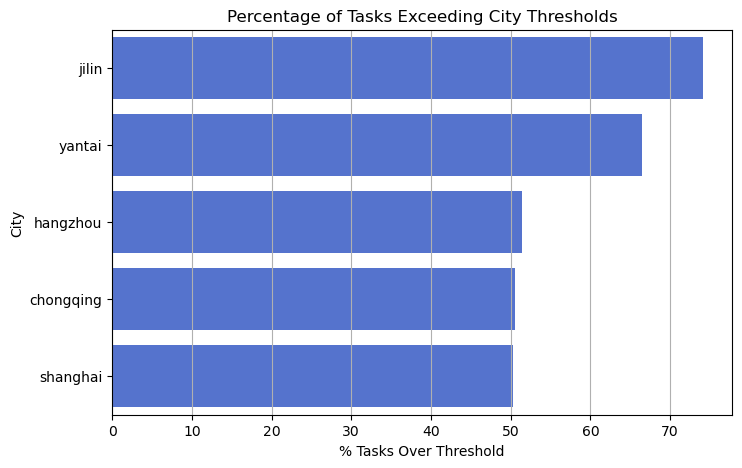

In [18]:
# % of tasks that exceeded the threshold
excess_summary["excess_pct"] = (excess_summary["excess_tasks"] / excess_summary["total_tasks"]) * 100
excess_summary = excess_summary.sort_values("excess_pct", ascending=False)

# Bar chart: % of flagged tasks per city
plt.figure(figsize=(8, 5))
sns.barplot(
    x="excess_pct",
    y=excess_summary.index,
    data=excess_summary.reset_index(),
    color="royalblue",
    dodge=False,
    legend=False
)
plt.title("Percentage of Tasks Exceeding City Thresholds")
plt.xlabel("% Tasks Over Threshold")
plt.ylabel("City")
plt.grid(axis="x")
plt.show()

#### Q4: How does pickup performance vary by time?

To uncover time-based patterns, we break down courier pickup delays by:

- **Hour of day** — to see if delays spike during certain parts of the day
- **Day of week** — to check if certain weekdays consistently underperform

This helps identify peak congestion periods or gaps in courier availability. We’ll look at both average delays and the percentage of excess delays for each time slice.

In [19]:
# Extracting hour and weekday from accept_time
pickup["hour"] = pickup["accept_time"].dt.hour
pickup["weekday"] = pickup["accept_time"].dt.day_name()

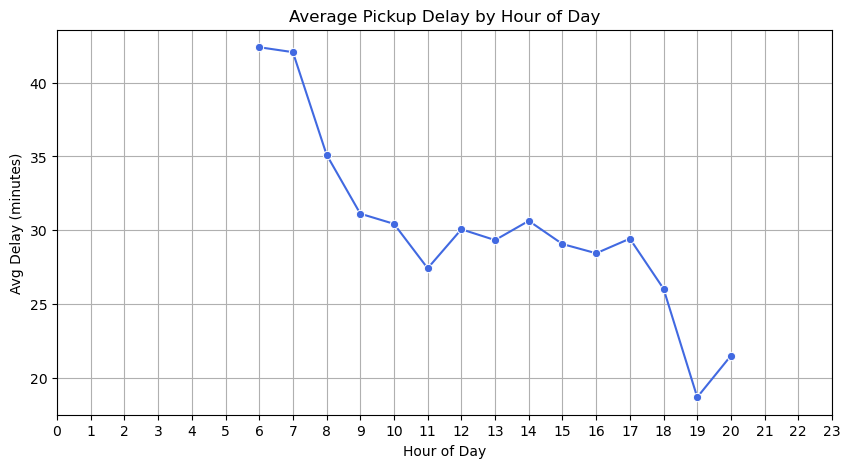

In [20]:
# Average pickup delay by hour
hourly_delay = pickup.groupby("hour")["pickup_delay_minutes"].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_delay.index, y=hourly_delay.values, marker="o", color="royalblue")
plt.title("Average Pickup Delay by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Avg Delay (minutes)")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

C:\Users\shamb\AppData\Local\Temp\ipykernel_12956\74617060.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_excess = pickup.groupby("weekday")["is_excess"].mean() * 100


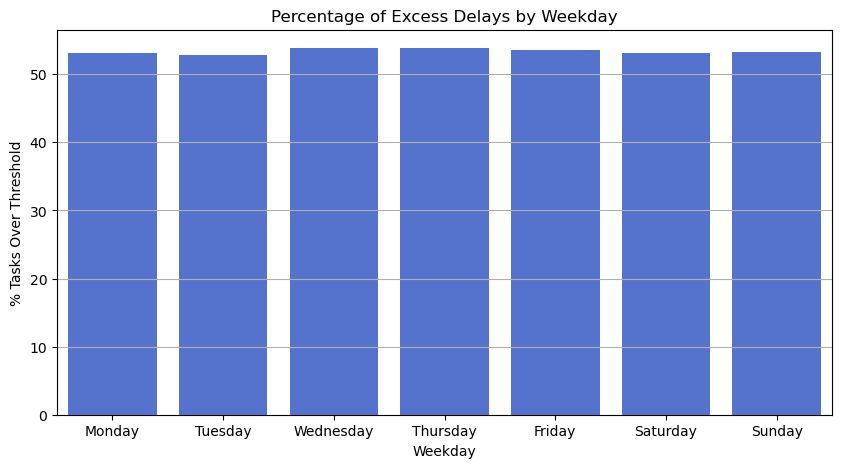

In [21]:
# Ordering weekdays correctly
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
pickup["weekday"] = pd.Categorical(pickup["weekday"], categories=ordered_days, ordered=True)

# % of excess delays by weekday
weekday_excess = pickup.groupby("weekday")["is_excess"].mean() * 100

plt.figure(figsize=(10, 5))
sns.barplot(x=weekday_excess.index, y=weekday_excess.values, color="royalblue")
plt.title("Percentage of Excess Delays by Weekday")
plt.xlabel("Weekday")
plt.ylabel("% Tasks Over Threshold")
plt.grid(axis="y")
plt.show()

#### Q5: How much avoidable time is being lost every day?

Excess delays don’t just impact customer satisfaction — they also represent **lost operational time**.

To quantify the scale of this problem, we calculate the **total excess minutes lost per day** across all cities. This tells us how much time is being wasted beyond acceptable thresholds, and can be used to:
- Evaluate the scale of resource inefficiency
- Track progress if interventions are applied
- Identify high-loss days that may correlate with specific events (e.g., weekends, weather, holidays)

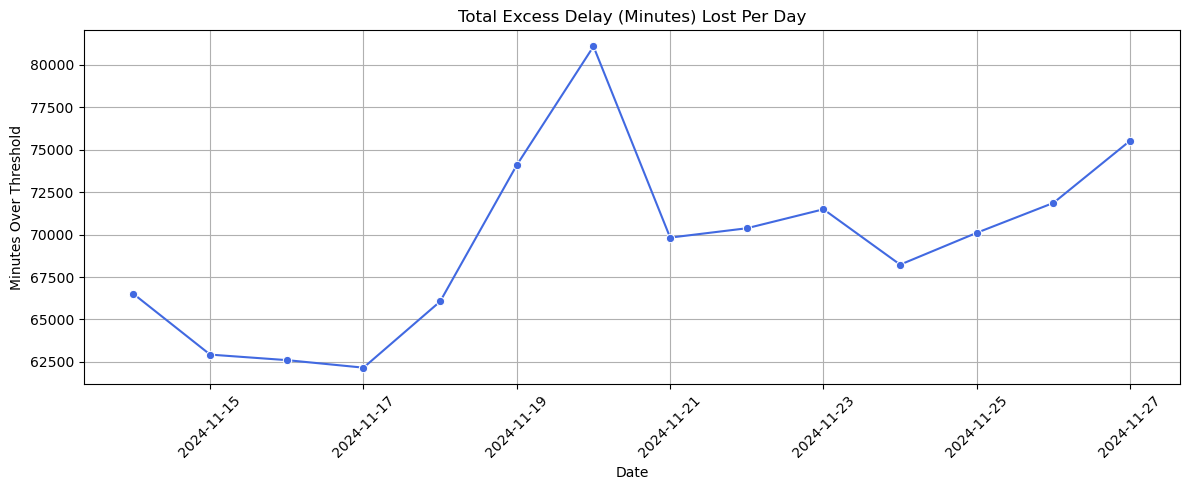

In [22]:
# Total excess minutes lost per day
daily_loss = pickup.groupby("ds")["excess_delay_minutes"].sum()

plt.figure(figsize=(12, 5))
sns.lineplot(x=daily_loss.index, y=daily_loss.values, marker="o", color="royalblue")
plt.title("Total Excess Delay (Minutes) Lost Per Day")
plt.xlabel("Date")
plt.ylabel("Minutes Over Threshold")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Q6: Estimating Operational Cost of Excess Delay

We used a **conservative rate of 0.1 RMB per excess minute** to estimate operational inefficiency caused by pickup delays.

This multiplier is derived from typical courier wages in China, which range from **15–30 RMB/hour** depending on the city and platform.  
0.1 RMB/min reflects a **safe lower bound** that captures:

- Courier time lost in waiting or repositioning
- SLA penalties or platform bonuses
- Missed task opportunities due to cascading delays

This model doesn’t reflect actual platform accounting — but it provides a reasonable way to translate time into **business-relevant cost**.

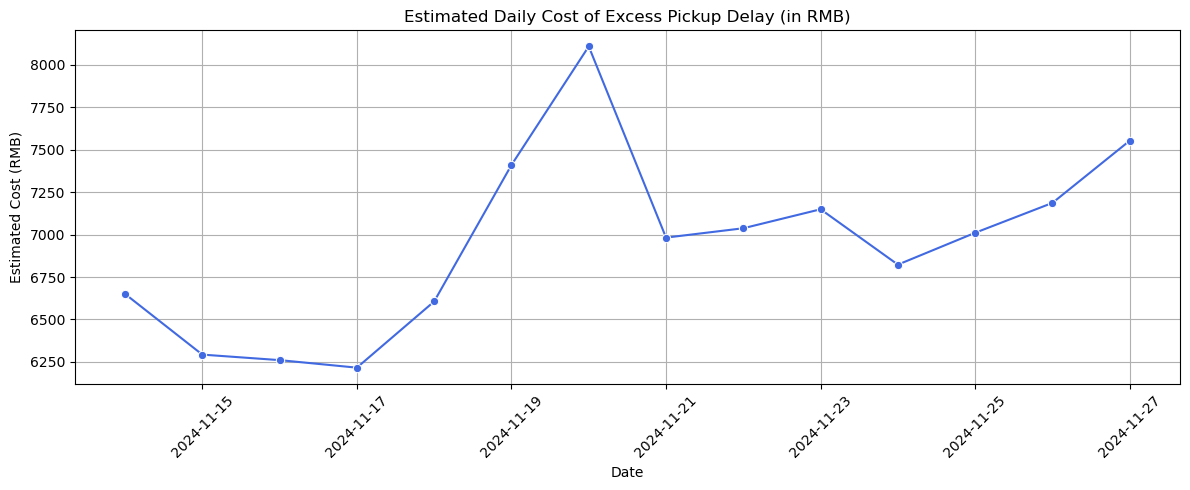

In [24]:
# Assumed cost per minute of excess delay
cost_per_min = 0.1  # RMB per minute (adjust if needed)

# Total cost per day
pickup["excess_cost_rmb"] = pickup["excess_delay_minutes"] * cost_per_min
daily_cost = pickup.groupby("ds")["excess_cost_rmb"].sum()

# Plot
plt.figure(figsize=(12, 5))
sns.lineplot(x=daily_cost.index, y=daily_cost.values, marker="o", color="royalblue")
plt.title("Estimated Daily Cost of Excess Pickup Delay (in RMB)")
plt.xlabel("Date")
plt.ylabel("Estimated Cost (RMB)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

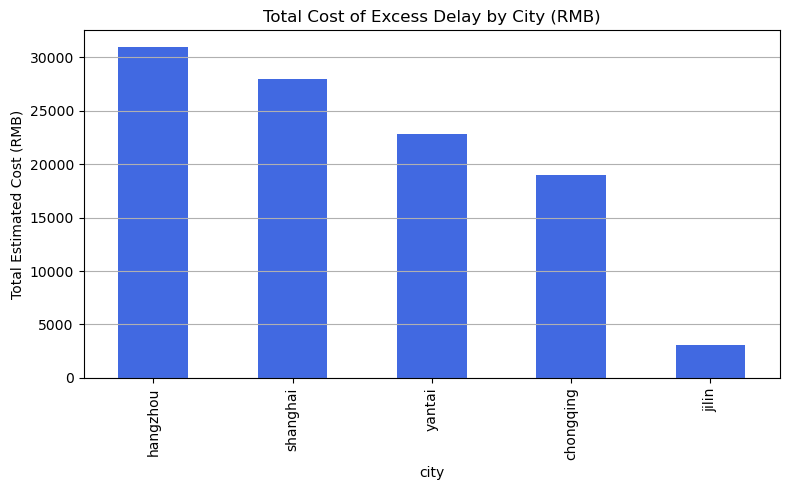

In [26]:
# Cost per city
city_cost = pickup.groupby("city")["excess_cost_rmb"].sum().sort_values(ascending=False)
city_cost.plot(kind="bar", figsize=(8, 5), color="royalblue", title="Total Cost of Excess Delay by City (RMB)")
plt.ylabel("Total Estimated Cost (RMB)")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

### Interpreting the Cost of Excess Pickup Delay

Even without converting time to dollars, it's clear that courier delays come at a cost.

Key Takeaways:
- On the worst day, excess delay across cities translated to **over 8,000 RMB lost** — in just one day.
- **Shanghai** contributed the most in absolute cost due to high task volume, even though its average performance was relatively strong.
- **Jilin and Yantai**, despite lower workloads, had disproportionately high costs — driven by chronic excess delays.

This cost framing adds financial urgency to what would otherwise seem like “just a few extra minutes.”

#### Q6: Can we forecast future responsiveness trends?

To monitor how pickup responsiveness evolves over time, we track the **7-day rolling average** of pickup delays.

This smooths out short-term variation and highlights longer-term trends in performance.

If the rolling average is rising, it may indicate operational strain; if it’s falling, interventions or efficiency gains may be working.

This method can also support early warning systems or staffing forecasts.

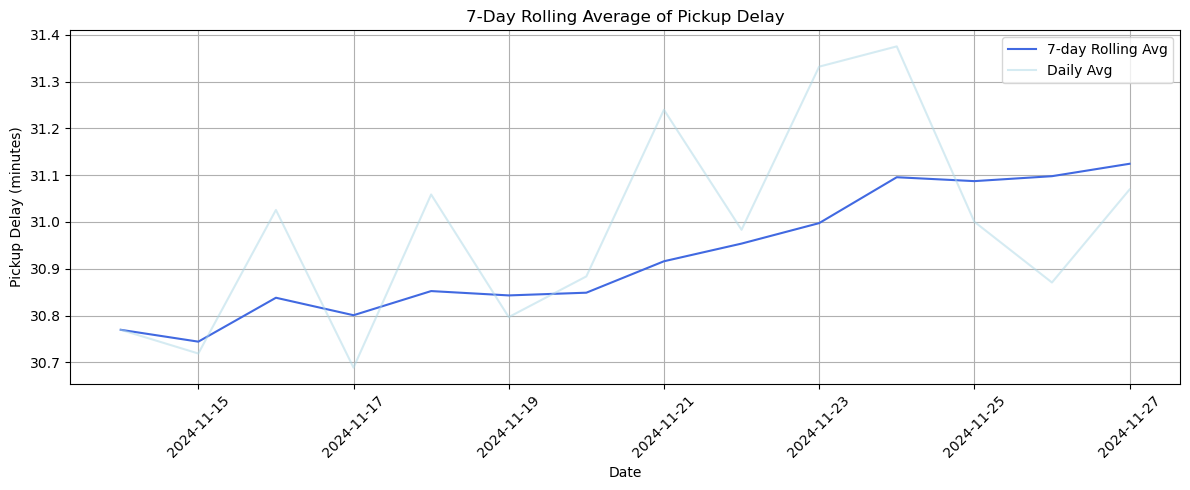

In [27]:
# Daily average pickup delay
daily_avg_delay = pickup.groupby("ds")["pickup_delay_minutes"].mean()

# 7-day rolling average
rolling_avg_delay = daily_avg_delay.rolling(window=7, min_periods=1).mean()

# Plot
plt.figure(figsize=(12, 5))
sns.lineplot(x=rolling_avg_delay.index, y=rolling_avg_delay.values, color="royalblue", label="7-day Rolling Avg")
sns.lineplot(x=daily_avg_delay.index, y=daily_avg_delay.values, color="lightblue", label="Daily Avg", alpha=0.5)
plt.title("7-Day Rolling Average of Pickup Delay")
plt.xlabel("Date")
plt.ylabel("Pickup Delay (minutes)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Forecasting Future Pickup responsiveness – Not Performed Due to Insufficient Data

Forecasting pickup responsiveness can provide valuable insights into whether delays are expected to rise or fall in the future. However, time series models like Holt-Winters and ARIMA require a **sufficient amount of historical data** to make accurate predictions.

In our case, the dataset contains only a **short span of daily records**, with fewer than 28 days of pickup activity. This limits our ability to:

- Capture recurring patterns like weekly cycles (needed for seasonal models)
- Train models on meaningful trends without overfitting
- Generate reliable forecasts that hold any predictive power

As a result, any forecast generated from this dataset would be statistically weak and potentially misleading.

Instead, we focus on **observed trends** (e.g., 7-day rolling average) to monitor performance and suggest using forecasting only when a larger volume of time-stamped data is available in the future.